In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

matplotlib.rcParams.update({'font.size': 18})

In [2]:
NUM_BINS = 10
plot_colors = [mcolors.TABLEAU_COLORS[x] for x in mcolors.TABLEAU_COLORS.keys()]*2
line_styles = ["--", "-", ":", "-.", (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]*2

In [3]:
DATA_PATH = "/mnt/0228/Minist_logs"
DATASET = "SplitMNIST"
MODEL_NAME = "SimpleMLP"
NUM_EXPERIENCES = 5

In [4]:
# all combinations of training
run2name = {
    "r_nst_npp_1" : "Replay_NoSelfTraining_NoPostProcessing0",
    "r_nst_npp_2" : "Replay_NoSelfTraining_NoPostProcessing1",
    "r_nst_npp_3" : "Replay_NoSelfTraining_NoPostProcessing2",

    "r_st_npp_1" : "Replay_SelfTraining_0.025_NoPostProcessing0",
    "r_st_npp_2" : "Replay_SelfTraining_0.025_NoPostProcessing1",
    "r_st_npp_3" : "Replay_SelfTraining_0.025_NoPostProcessing2",

    "r_nst_pp_ts_1" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling0",
    "r_nst_pp_ts_2" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling1",
    "r_nst_pp_ts_3" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling2",

    "r_nst_pp_vs_1" : "Replay_NoSelfTraining_PostProcessing_VectorScaling0",
    "r_nst_pp_vs_2" : "Replay_NoSelfTraining_PostProcessing_VectorScaling1",
    "r_nst_pp_vs_3" : "Replay_NoSelfTraining_PostProcessing_VectorScaling2",

    "r_nst_pp_ms_1" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling0",
    "r_nst_pp_ms_2" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling1",
    "r_nst_pp_ms_3" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling2",

    "r_nst_pp_ts_md_1" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData0",
    "r_nst_pp_ts_md_2" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData1",
    "r_nst_pp_ts_md_3" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData2",

    "r_nst_pp_vs_md_1" : "Replay_NoSelfTraining_PostProcessing_VectorScaling_MixedData0",
    "r_nst_pp_vs_md_2" : "Replay_NoSelfTraining_PostProcessing_VectorScaling_MixedData1",
    "r_nst_pp_vs_md_3" : "Replay_NoSelfTraining_PostProcessing_VectorScaling_MixedData2",

    "r_nst_pp_ms_md_1" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling_MixedData0",
    "r_nst_pp_ms_md_2" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling_MixedData1",
    "r_nst_pp_ms_md_3" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling_MixedData2",
}

In [5]:
run2label = {
    "r_nst_npp_1" : "Replay",
    "r_nst_npp_2" : "Replay",
    "r_nst_npp_3" : "Replay",

    "r_st_npp_1" : "Replay+HR",
    "r_st_npp_2" : "Replay+HR",
    "r_st_npp_3" : "Replay+HR",

    "r_nst_pp_ts_1" : "Replay+TS",
    "r_nst_pp_ts_2" : "Replay+TS",
    "r_nst_pp_ts_3" : "Replay+TS",

    "r_nst_pp_vs_1" : "Replay+VS",
    "r_nst_pp_vs_2" : "Replay+VS",
    "r_nst_pp_vs_3" : "Replay+VS",

    "r_nst_pp_ms_1" : "Replay+MS",
    "r_nst_pp_ms_2" : "Replay+MS",
    "r_nst_pp_ms_3" : "Replay+MS",

    "r_nst_pp_ts_md_1" : "Replay+TS+RC",
    "r_nst_pp_ts_md_2" : "Replay+TS+RC",
    "r_nst_pp_ts_md_3" : "Replay+TS+RC",
    
    "r_nst_pp_vs_md_1" : "Replay+VS+RC",
    "r_nst_pp_vs_md_2" : "Replay+VS+RC",
    "r_nst_pp_vs_md_3" : "Replay+VS+RC",

    "r_nst_pp_ms_md_1" : "Replay+MS+RC",
    "r_nst_pp_ms_md_2" : "Replay+MS+RC",
    "r_nst_pp_ms_md_3" : "Replay+MS+RC",
}

In [6]:
running_accuracy = []
running_ece = []
final_accuracy = []
final_ece = []
bins = None
ece_hist_vals = []

for k, name in run2name.items():
    print(f">> {name} <<")
    with open(f"{DATA_PATH}/{DATASET}_{MODEL_NAME}_{name}_dict", "rb") as file:
        data = pickle.load(file)

        # print("\n---- ACCURACY ----")

        metric_str = "Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp"
        m = []
        for i in range(len(data)):
            cur_exp_dict = data[i]
            cur_exp_acc = 0
            # compute the average over the experiences trained so far (i)
            for j in range(i+1):
                # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
                cur_exp_acc += cur_exp_dict[metric_str + f"{j:03d}"]
            m.append(cur_exp_acc/(i+1))
        
        # duplicate for JointTraining
        if len(m) < NUM_EXPERIENCES:
            m = m*NUM_EXPERIENCES
        running_accuracy.append((k, m))
        final_accuracy.append((k, running_accuracy[-1][-1][-1]))
        # print(k, m, running_accuracy[-1][-1][-1])

        # print("\n---- ECE ----")

        metric_str = "ECE_Exp/eval_phase/test_stream/Task000/Exp"
        m = []
        for i in range(len(data)):
            cur_exp_dict = data[i]
            cur_exp_ece = 0
            # compute the average over the experiences trained so far (i)
            for j in range(i+1):
                # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
                cur_exp_ece += cur_exp_dict[metric_str + f"{j:03d}"]
            # m.append(cur_exp_ece/(i+1))
            m.append((cur_exp_ece/(i+1))*100)
        
        # duplicate for JointTraining
        if len(m) < NUM_EXPERIENCES:
            m = m*NUM_EXPERIENCES
        running_ece.append((k, m))
        final_ece.append((k, running_ece[-1][-1][-1]))
        # print(k, m, running_ece[-1][-1][-1])

        # print("\n---- ECE HISTOGRAMS ----")

        metric_str = "ExpECEHistogram/eval_phase/test_stream/Exp"
        m = []
        i = -1 # after last experience
        cur_exp_dict = data[i]
        for j in range(NUM_EXPERIENCES):
            # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
            fig = cur_exp_dict[metric_str + f"{j:03d}"]
            axes_list = fig.get_axes()
            for ax in axes_list:
                for line in ax.get_lines()[-1:]:
                    x_data = line.get_xdata()
                    y_data = line.get_ydata()
                    # print({'x': x_data, 'y': y_data})
                    if bins is None:
                        bins = x_data
                    m.append(y_data)
        # print(bins, m)
        bin_vals = []
        for i in range(len(bins)):
            x = []
            for j in range(len(m)):
                # print(j, i, m[j][i])
                x.append(m[j][i])
            mean = np.mean(x)
            std = np.std(x)
            bin_vals.append((mean, std))
        # print(k, bin_vals)
        ece_hist_vals.append((k, bin_vals))

>> Replay_NoSelfTraining_NoPostProcessing0 <<
>> Replay_NoSelfTraining_NoPostProcessing1 <<
>> Replay_NoSelfTraining_NoPostProcessing2 <<
>> Replay_SelfTraining_0.025_NoPostProcessing0 <<
>> Replay_SelfTraining_0.025_NoPostProcessing1 <<
>> Replay_SelfTraining_0.025_NoPostProcessing2 <<
>> Replay_NoSelfTraining_PostProcessing_TemperatureScaling0 <<
>> Replay_NoSelfTraining_PostProcessing_TemperatureScaling1 <<
>> Replay_NoSelfTraining_PostProcessing_TemperatureScaling2 <<
>> Replay_NoSelfTraining_PostProcessing_VectorScaling0 <<
>> Replay_NoSelfTraining_PostProcessing_VectorScaling1 <<
>> Replay_NoSelfTraining_PostProcessing_VectorScaling2 <<
>> Replay_NoSelfTraining_PostProcessing_MatrixScaling0 <<
>> Replay_NoSelfTraining_PostProcessing_MatrixScaling1 <<
>> Replay_NoSelfTraining_PostProcessing_MatrixScaling2 <<
>> Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData0 <<
>> Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData1 <<
>> Replay_NoSelfTraining_Post

In [7]:
acc_data = {}
acc_plot_data = {}
for i, (name, vals) in enumerate(running_accuracy):
    if run2label[name] not in acc_data:
        acc_data[run2label[name]] = [[] for _ in range(NUM_EXPERIENCES)]
    for i, val in enumerate(vals):
        acc_data[run2label[name]][i].append(val)
for i, (name, data) in enumerate(acc_data.items()):
    for values in data:
        mean = np.mean(values)
        std = np.std(values)
        if name not in acc_plot_data:
            acc_plot_data[name] = [[], []]
        acc_plot_data[name][0].append(mean)
        acc_plot_data[name][1].append(std)

ece_data = {}
ece_plot_data = {}
for i, (name, vals) in enumerate(running_ece):
    if run2label[name] not in ece_data:
        ece_data[run2label[name]] = [[] for _ in range(NUM_EXPERIENCES)]
    for i, val in enumerate(vals):
        ece_data[run2label[name]][i].append(val)
for i, (name, data) in enumerate(ece_data.items()):
    for values in data:
        mean = np.mean(values)
        std = np.std(values)
        if name not in ece_plot_data:
            ece_plot_data[name] = [[], []]
        ece_plot_data[name][0].append(mean)
        ece_plot_data[name][1].append(std)

rel_data = {}
rel_plot_data = {}
for i, (name, vals) in enumerate(ece_hist_vals):
    # print(i, name, vals)
    if run2label[name] not in rel_data:
        rel_data[run2label[name]] = [[] for _ in range(NUM_BINS)]
    for i, val in enumerate(vals):
        rel_data[run2label[name]][i].append(val[0])
for i, (name, data) in enumerate(rel_data.items()):
    # print(i, name, data)
    for values in data:
        mean = np.mean(values)
        std = np.std(values)
        if name not in rel_plot_data:
            rel_plot_data[name] = [[], []]
        rel_plot_data[name][0].append(mean)
        rel_plot_data[name][1].append(std)

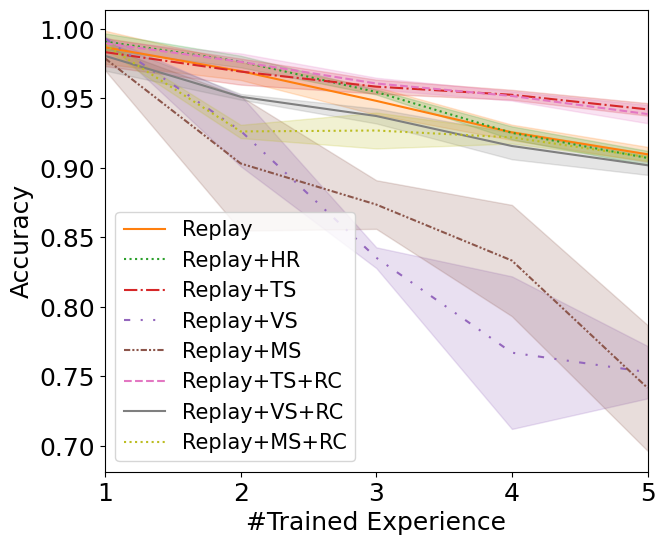

In [8]:
# PLOT 1: Average accuracy on all experiences after training on exp j

plt.figure(figsize=(7, 6))
x_axis = list(range(1, NUM_EXPERIENCES+1))
for i, (name, (means, stds)) in enumerate(acc_plot_data.items()):
    plt.plot(x_axis, means, color=plot_colors[i+1], label=name, linestyle=line_styles[i+1])
    l = [means[i] - stds[i] for i in range(len(means))]
    u = [means[i] + stds[i] for i in range(len(means))]
    plt.fill_between(x_axis, l, u, alpha=0.2, color=plot_colors[i+1])
# plt.title(f'{DATASET} - Accuracy')
plt.xlabel('#Trained Experience')
plt.ylabel('Accuracy')
plt.xlim(1, NUM_EXPERIENCES)
plt.xticks(x_axis, x_axis)
plt.legend(loc='best', fontsize='small')
plt.show()

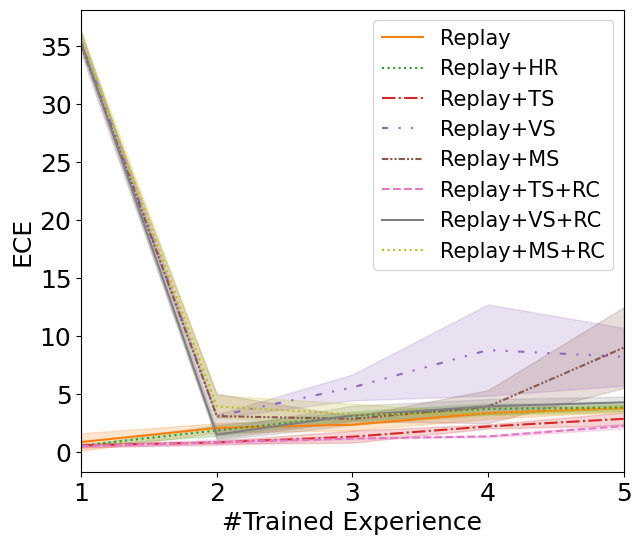

In [9]:
# PLOT 2: Average ece on all experiences after training on exp j

plt.figure(figsize=(7, 6))
x_axis = list(range(1, NUM_EXPERIENCES+1))
for i, (name, (means, stds)) in enumerate(ece_plot_data.items()):
    plt.plot(x_axis, means, color=plot_colors[i+1], label=name, linestyle=line_styles[i+1])
    l = [means[i] - stds[i] for i in range(len(means))]
    u = [means[i] + stds[i] for i in range(len(means))]
    plt.fill_between(x_axis, l, u, alpha=0.2, color=plot_colors[i+1])
# plt.title(f'{DATASET} - ECE')
plt.xlabel('#Trained Experience')
plt.ylabel('ECE')
plt.xlim(1, NUM_EXPERIENCES)
plt.xticks(x_axis, x_axis)
plt.legend(loc='best', fontsize='small')
plt.show()

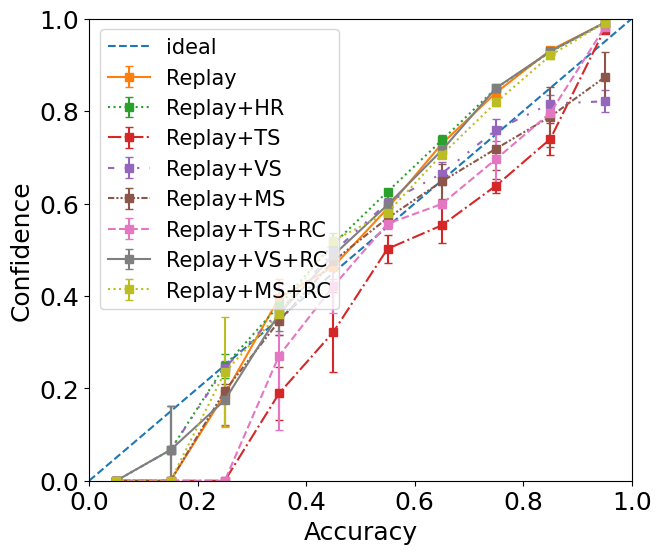

In [10]:
# PLOT 3: Reliability diagram at the end of the training process across all experiences

plt.figure(figsize=(7, 6))
plt.plot([0, 1], [0, 1], linestyle=line_styles[0], label='ideal', color=plot_colors[0])
for i, (name, (means, stds)) in enumerate(rel_plot_data.items()):
    plt.errorbar(bins, means, yerr=stds, marker="s", linestyle=line_styles[i+1], capsize=3, capthick=1, color=plot_colors[i+1], label=name)
plt.legend(loc='best', fontsize='small')
# plt.title(f'{DATASET} - Reliability Diagram')
plt.xlabel('Accuracy')
plt.ylabel('Confidence')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

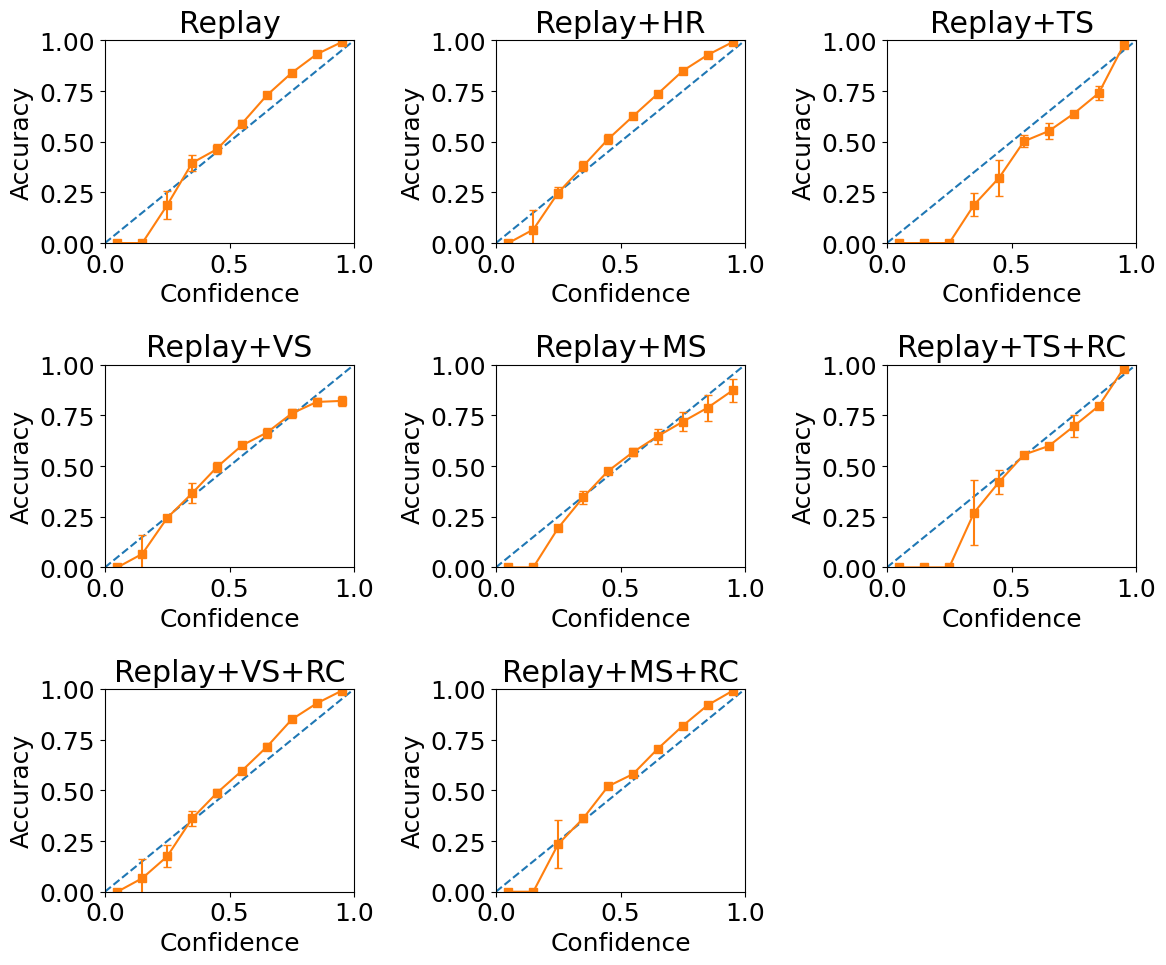

In [11]:
# PLOT 4: Reliability diagram at the end of the training process across all experiences (each calibration method)

fig, axs_ = plt.subplots(3, 3, figsize=(12, 10))
axs = axs_.flatten()
for i, (name, (means, stds)) in enumerate(rel_plot_data.items()):
    axs[i].plot([0, 1], [0, 1], linestyle=line_styles[0], label='ideal', color=plot_colors[0])
    axs[i].errorbar(bins, means, yerr=stds, marker="s", linestyle=line_styles[1], capsize=3, capthick=1, color=plot_colors[1], label=name)
    axs[i].set_ylim(0, 1)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylabel("Accuracy")
    axs[i].set_xlabel("Confidence")
    axs[i].set_title(name)
fig.delaxes(axs_[-1][-1])
plt.tight_layout()
plt.show()